In [8]:
# Import libraries

import numpy as np
import gymnasium as gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Cartpole environment

env = gym.make("CartPole-v1")

In [5]:
# Build model

model = Sequential([
    Input(shape=env.observation_space.shape),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(env.action_space.n, activation='linear')
])
model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# Make a wrapper class for episode frames

class Frame:
    '''
    Wrapper for frames of each episode
    '''
    state = None         # current state
    action = None        # action
    reward = 0           # reward
    next_state = None    # next state
    terminated = False   # termination flag
    
    def __init__(self, state, action, next_state, reward, terminated):
        '''
        Constructs this frame object
        INPUT
            state; current state
            action; taken action
            reward; received reward
            next_state; next state
            termination; boolean termination flag
        '''
        self.state = state
        self.action = action
        self.next_state = next_state
        self.reward = reward
        self.terminated = terminated
                        
            
# Define capacitated queue for replay memory.            
            
class CapacitatedQueue:
    '''
    A queue with maximum capacity. If any items are added when at capacity, then oldest items are pushed out.
    '''
    collection = []  # items in this collection
    capacity = 128   # max capacity
    next_ind = 0     # index of the next item to be added
    
    def __init__(self, capacity=128):
        '''
        Intializes this model
        INPUT
            capacity; the maximum capacity of this colleciotn
        '''
        self.capacity = capacity
        self.next_ind = 0
        self.collection = []
        
    def __len__():
        '''
        RETURNS length of the collection
        '''
        return len(self.collection)
        
    def add(self, item):
        '''
        Adds the given item into the collection.
        If the collection is at capacity, push out oldest item
        '''
        # If not at capacity, add in item
        if len(self.collection) < self.capacity:
            self.collection.append(item)
            
        # If at capacity, replace oldest item
        else:
            self.collection[self.next_ind] = item
            
        # Track the index of the next/oldest item
        self.next_ind = (self.next_ind + 1) % self.capacity

    def sample(self, size=1):
        '''
        RETURNS a (with-replacement) sample of the given size from the collection
        '''
        return np.random.choice(self.collection, size, replace=True).tolist()
    
    def get_next(self):
        '''
        RETURNS the next item in the collection
        '''
        return self.collection[(next_ind - 1) % self.capacity]
    
    
# Construct class for deep-q learning model
    
class DeepQLearner:
    '''
    Class for a Deep-q learning model
    '''
    env = None                             # associated envionment
    q_estimator = None                     # the fitted function to estimate Q, like a neural network
    state_processor = lambda state: state  # function for converting the environment states into approximator inputs (e.g. a one-hot-encoder)
    
    def __init__(self, env, q_estimator, state_processor=(lambda state:state)):
        '''
        Intializes this object
        INPUT
            env; environment
            q_estimator; trainable function to estimate Q
            state_processor; function for converting the environment states into approximator inputs
        '''
        self.env = env
        self.q_estimator = q_estimator
        self.state_processor = state_processor
        
    def get_action(self, state, epsilon=0.):
        '''
        Gets the action to take
        INPUT
            state; the current state, as would be input to the Q approximator
            epsilon; the epsilon-greedy parameter
                if 0; plays full greedy
                if -1; plays soft-max
        RETURNS
            action to take
        '''
        # Explore
        if (epsilon > 0) and (np.random.uniform() < epsilon):
            return self.env.action_space.sample()
        
        # Softmax
        elif epsilon == -1:
            probs = np.exp(self.q_estimator.predict(state.reshape(1, -1), verbose=0))
            probs = probs / np.sum(probs)
            return np.random.choice(self.env.action_space.n, p=probs.reshape(-1,))
        
        # Greedy
        return np.argmax(self.q_estimator.predict(state.reshape(1, -1), verbose=0))
            
    def train(self, n_steps=10**3, epsilon=0.2, training_delay=32, batch_size=32, discount_factor=1., replay_capacity=128):
        '''
        Trains this model
        INPUT
            n_steps; number of steps to train
            epsilon; epsilon-greedy threshold
            training_delay; number of steps to train before fitting approximator
            batch_size; number of frames to train approximator with
            discount_factor; discount factor in bellman
            replay_capacity; the capacity of the replay memory
        RETURNS
            list of episode rewards
        '''
        # Initialize
        replay_memory = CapacitatedQueue(replay_capacity)
        episode_counter = 0
        delay_counter = 0
        reward_history = [0]
        
        # First state
        state, _ = self.env.reset()
        state = self.state_processor(state)
        
        # Train for each step
        pbar = tqdm(range(n_steps))
        for _ in pbar:
            
            # Get action
            action = self.get_action(state, epsilon)
            
            # Make step
            next_state, reward, terminated, _, _ = self.env.step(action)
            next_state = self.state_processor(next_state)
            
            # Save frame
            replay_memory.add(Frame(state, action, next_state, reward, terminated))
            reward_history[-1] += reward

            # If terminated, record reward and reset
            if terminated:
                state, _ = self.env.reset()
                state = self.state_processor(state)
                pbar.set_description(f"Last episode reward: {reward_history[-1]}")
                pbar.update()
                reward_history.append(0)
            else:
                state = next_state
                
            # If training_delay steps have occurred, then train
            delay_counter += 1
            if delay_counter >= training_delay:
                delay_counter = 0
                
                # Get minibatch params
                frame_batch = replay_memory.sample(batch_size)
                states = np.array([frame.state for frame in frame_batch])
                next_states = np.array([frame.next_state for frame in frame_batch])
                rewards = np.array([frame.reward for frame in frame_batch])
                actions = np.array([frame.action for frame in frame_batch])
                terminateds = np.array([frame.terminated for frame in frame_batch])
                
                # Get training targets
                targets = self.q_estimator.predict(states, verbose=0)
                old_estimates = targets[range(batch_size), actions]
                targets[range(batch_size), actions] = rewards
                targets[range(batch_size), actions] += discount_factor * terminateds * np.max(self.q_estimator.predict(next_states, verbose=0), axis=1)
                
                # Train
                self.q_estimator.fit(states, targets, epochs=1, verbose=0)
        
        return reward_history

In [ ]:
# Initialize learner

dql = DeepQLearner(env, model)
reward_history = []

In [7]:
# Learn

reward_history += dql.train(n_steps=10 ** 4, epsilon=1., batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history += dql.train(n_steps=10 ** 4, epsilon=0.5, batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history += dql.train(n_steps=10 ** 4, epsilon=0.1, batch_size=64, training_delay=8, replay_capacity=10**4)

Last episode reward: 22.0: 100%|██████████| 10000/10000 [08:35<00:00, 19.41it/s]


In [11]:
reward_history += dql.train(n_steps=10 ** 4, epsilon=0.1, batch_size=64, training_delay=8, replay_capacity=10**4)

Last episode reward: 11.0: 100%|██████████| 10000/10000 [08:46<00:00, 19.01it/s]


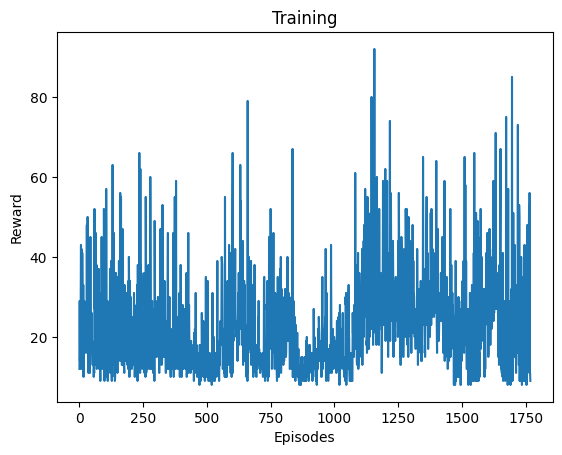

In [12]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Training")
plt.show()